In [1]:
import numpy as np                                                                        
import matplotlib.pyplot as plt
import pyCloudy as pc
import pyneb as pn
from astropy    import constants as const
from astropy.io import ascii
import pandas as pd
from scipy import interpolate
import warnings
from scipy.integrate import quad, IntegrationWarning
import scipy.integrate as integrate
from numpy import log10, exp

kpc = const.kpc.cgs.value

atom = ['Lya','HeII','CIV']

def read_file(path_way, atom):
    Mod = pc.CloudyModel(path_way, cloudy_version_major=23)
    Mod.ionic_names

    N_H = sum(Mod.dr*Mod.nH)
    # solar_metallicitiy from von Steiger et al. 2016
    frac_He = 1.0E-01
    frac_C = 4.47E-04
    frac_O = 6.61E-04
    frac_N = 9.33E-05
    frac_Mg = 7.08E-05

    N_HI = sum(Mod.dr*Mod.nH*Mod.get_ionic('H',0))
    N_HII = sum(Mod.dr*Mod.nH*Mod.get_ionic('H',1))
    N_HeII = frac_He*sum(Mod.dr*Mod.nH*Mod.get_ionic('He',1))
    N_OVI = frac_O*sum(Mod.dr*Mod.nH*Mod.get_ionic('O',5))
    N_NV = frac_N*sum(Mod.dr*Mod.nH*Mod.get_ionic('N',4))
    N_CIV = frac_C*sum(Mod.dr*Mod.nH*Mod.get_ionic('C',3))

    num = len(Mod.nH)
    r_CIV = path_way +  '.ele_C'
    f = open(r_CIV,'r')
    header = f.readline()
    CIV_frac = np.zeros(num)
    i = 0
    for line in f:
        line = line.strip()
        columns = line.split()
        j = float(columns[4])
        CIV_frac[i] = j
        i = i + 1

    r_He = path_way +  '.ele_He'
    f = open(r_He,'r')
    header = f.readline()
    HeII_frac = np.zeros(num)
    i = 0
    for line in f:
        line = line.strip()
        columns = line.split()
        j = float(columns[2])
        HeII_frac[i] = j
        i = i + 1



    n_H= Mod.nH
    n_He = n_H*frac_He
    n_C = n_H*frac_C
    nden_CIV = CIV_frac*n_C
    nden_HeII = HeII_frac*n_He



    if atom == 'CIV':
        Cloudy_Lum = float(Mod.get_emis_vol('C__4_154819A')) + float(Mod.get_emis_vol('C__4_155078A'))
        Cloudy_emis = (Mod.get_emis('C__4_154819A')) + (Mod.get_emis('C__4_155078A'))
        Cloudy_den = nden_CIV
    elif atom == 'Lya':
        Cloudy_Lum= float(Mod.get_emis_vol('H__1_121567A'))
        Cloudy_emis = Mod.get_emis('H__1_121567A')
        Cloudy_den = n_H
    elif atom == 'HeII':
        Cloudy_Lum = float(Mod.get_emis_vol('HE_2_164043A'))
        Cloudy_emis = Mod.get_emis('HE_2_164043A')
        Cloudy_den = nden_HeII
    return Cloudy_Lum , Cloudy_emis ,Cloudy_den

def radius(path, atom):
    Mod = pc.CloudyModel(path, cloudy_version_major=23)
    radius = Mod.radius/kpc
    radius_kpc =Mod.radius 
    dr = Mod.dr 
    return radius, radius_kpc, dr

def make_data_file(path,atom):
    lum ,emis ,den = read_file(path,atom)
    radius_R , radius_kpc , dr=  radius(path,atom)
    tt =  pd.DataFrame(np.column_stack((radius_R,emis,den)))
    tt.to_csv('/home/jin/T_Cloudy/{}_cloudy.txt'.format(atom), sep='\t',index=False,header =False)
    tt.to_csv('/home/jin/RT_code/{}_cloudy.txt'.format(atom), sep='\t',index = False,header=False)
    return print("make data file!")





def SB(z, radius_kpc, emissivity, dr):
    r_min, r_max = radius_kpc.min(), radius_kpc.max()
    Project_R = np.linspace(0, 100, 70) * kpc
    N = len(Project_R)
    surface_brightness = np.zeros(N)
    Lumin = np.zeros(N)

    from scipy.interpolate import interp1d
    emis_interp = interp1d(radius_kpc, emissivity, bounds_error=False, fill_value=0)
    
    for ii, R in enumerate(Project_R):
        # 적분 함수 정의
        def integrand(r):
            if r < R:
                return 0
            else:
                emis = emis_interp(r)
                return emis * r / np.sqrt(r**2 - R**2)
            
        surface_brightness[ii], _ = quad(integrand, R, r_max)
        surface_brightness[ii] *= 2 / (1+z)**4
    
    def lumin_integrand(R):
        return 2 * np.pi * R * np.interp(R, Project_R, surface_brightness)
    
    Lumin, _ = quad(lumin_integrand, 0, r_max)
    
    return Project_R / kpc, surface_brightness, Lumin

def RT_SB(path):
    name = ['radius','SB_K','SB_H','SB_tot','1','2','3']
    data_sp = pd.read_csv(path, sep='\s+', header=None,names=name)
    rad, SB_t, SB_k,SB_h =  data_sp['radius'].to_numpy(),data_sp['SB_tot'].to_numpy(),data_sp['SB_K'].to_numpy(),data_sp['SB_H'].to_numpy()
    return rad*100, rad*100*kpc, SB_t 

def find_y(x_find,x,y):
    ii = int(np.where(x <= x_find)[0][-1])
    # print(ii)
    y_find = (y[ii+1] -y[ii]) / (x[ii+1] - x[ii])*(x_find - x[ii]) + y[ii]
    return y_find

warnings.filterwarnings("ignore", category=IntegrationWarning)

path_LT = r'/home/jin/T_Cloudy/data_CLOUDY_setting//OTS_n_LT_y/CIV_Lumin_42' # no OTS , yes LT For CIV

RT_path_HeII =r'/home/jin/T_Cloudy/data_HeII_wo_s/N_atom000E+00_Vexp000E+00_Vemit000E+00_tauD000E+00_Vran000E+00radi.dat'
RT_path_CIV = r'/home/jin/T_Cloudy/data_CIV_wo_s/N_atom000E+00_Vexp000E+00_Vemit000E+00_tauD000E+00_Vran000E+00radi.dat'


# make_data_file(path_LT,'CIV')
# make_data_file(path_LT,'HeII')


warng pyCloudy config: pyCloudy works better with matplotlib Triangulation


In [2]:
def calculate_order_and_value(value):
    """ 주어진 값에 대해 변환된 값과 해당 order 반환 """

    if value == 0 :
        return "000" , 0
    elif value == 1:
        return int(value * 100), 0
    elif value < 100:
        return int(value * 10), 1
    elif value < 1000:
        return int(value), 2

    return int(value / 10), 3


def RT_make_parameter(v_out, v_emit, v_rand, atom):
    # 기본값 설정
    radius_RT, radius_kpc_RT, SB_RT = np.array([0]), np.array([0]), np.array([0])
    radius_CL, sb_CL = np.array([0]), np.array([0])
    normal_RT, normal_CL = 1, 1  # ZeroDivisionError 방지

    if v_out == 0:
        expand, vout_order = "000", 0
    else:
        expand, vout_order = v_out, 2
    # print(v_emit)
    emit, emit_order = calculate_order_and_value(v_emit)    
    # print(emit,emit_order)
    rand, rand_order = calculate_order_and_value(v_rand)
    # print(rand)

    # 파일 경로 설정
    #ubuntu
    path_rt = (f'/home/jin/T_Cloudy/data_CIV_w_s/N_atom000E+00_'
                f'Vexp{expand}E+0{vout_order}_Vemit{emit}E+0{emit_order}_'
                f'tauD000E+00_Vran{rand}E+0{rand_order}radi.dat')
    #window
    # path_rt = (f'/home/jin/T_Cloudy/sb_cloudy/data_RT/N_atom000E+00_'
    #             f'Vexp{expand}E+0{vout_order}_Vemit{emit}E+0{emit_order}_'
    #             f'tauD000E+00_Vran{rand}E+0{rand_order}radi.dat')


    # RT_SB 함수 호출
    rt_output = RT_SB(path_rt)
    if rt_output is not None:
        radius_RT, radius_kpc_RT, SB_RT = rt_output

    # SB_RT 값이 None이거나 비어있을 경우 기본값 설정
    if SB_RT is None or len(SB_RT) == 0:
        SB_RT = np.array([0])
    normal_RT = np.sum(SB_RT) if np.sum(SB_RT) != 0 else 1

    print(f"make parameters of v_rand = {v_rand} km/s, v_exp = {v_out} km/s, v_emit = {v_emit} km/s for {atom}")

    # 추가 데이터 처리
    z_red_Shift = 0
    radius_data = radius(path_LT, atom)
    lum_data = read_file(path_LT, atom)
    sb_data = SB(z_red_Shift, radius_data[1], lum_data[1], radius_data[2])

    if sb_data is not None:
        radius_CL, sb_CL = sb_data[0], sb_data[1]

    # sb_CL 값이 None이거나 비어있을 경우 기본값 설정
    if sb_CL is None or len(sb_CL) == 0:
        sb_CL = np.array([0])
    normal_CL = np.sum(sb_CL) if np.sum(sb_CL) != 0 else 1

    return radius_RT, radius_kpc_RT, SB_RT / normal_RT 

In [3]:
atom_N = ['HeII','CIV']
def make_parameter(path,RT_path,atom):
    z_red_Shift = 0
    globals()['{}_radius'.format(atom)] , globals()['{}_radius_kpc'.format(atom)], globals()['dr_{}'.format(atom)] = radius(path,atom)
    globals()['{}_lum'.format(atom)] , globals()['{}_emis'.format(atom)] , globals()['{}_den'.format(atom)] = read_file(path,atom)
    globals()['{}_rt_radius'.format(atom)] , globals()['{}_rt_radius_kpc'.format(atom)], globals()['{}_rt_sb_t'.format(atom)] = RT_SB(RT_path)
    globals()['{}_p_radius'.format(atom)] , globals()['{}_SB'.format(atom)], globals()['{}_lum_SB'.format(atom)] = SB(z_red_Shift,globals()['{}_radius_kpc'.format(atom)],globals()['{}_emis'.format(atom)]  , globals()['dr_{}'.format(atom)]) # , globals()['rt_radius_kpc_{}'.format(atom)]
    return print("make parameters of {}".format(atom))

for atom in atom_N:
    make_parameter(path_LT,globals()['RT_path_{}'.format(atom)],atom)

make parameters of HeII
make parameters of CIV


Comparing RT results with Analytic solution

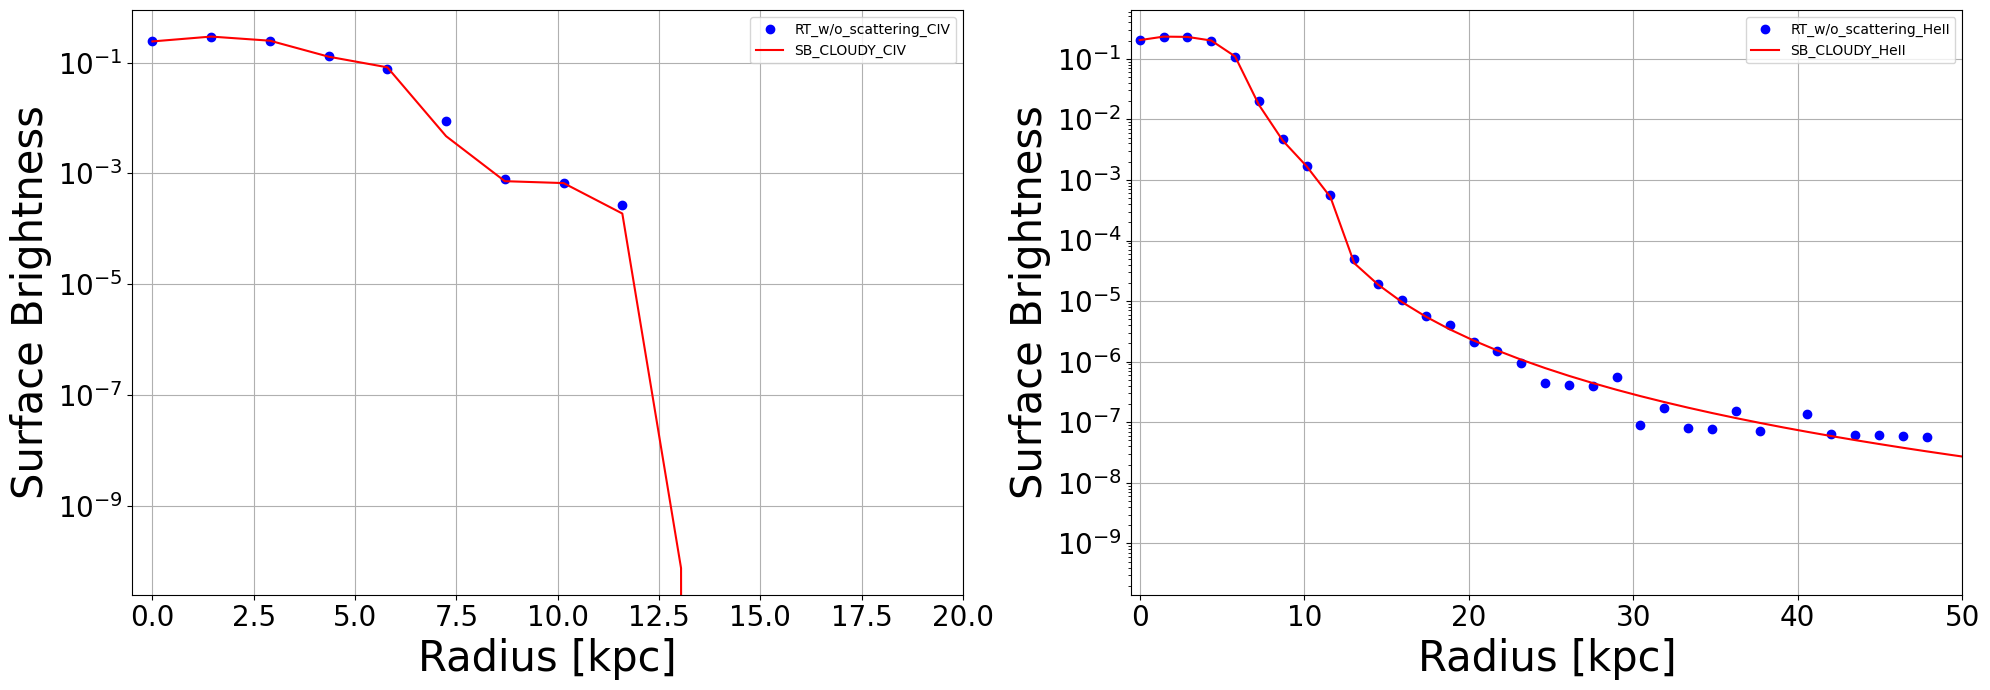

In [19]:
figure = plt.figure(1,figsize=(20,7))
plt.subplot(121)
normal = np.sum(CIV_rt_sb_t)
plt.plot(CIV_rt_radius ,CIV_rt_sb_t/ normal ,'bo',label='RT_w/o_scattering_CIV')
# plt.plot(radius_8/kpc/100 ,sb_t_8/normal,'bo')

normal = np.sum(CIV_SB)
plt.plot(CIV_p_radius , CIV_SB / normal  ,'r-', label='SB_CLOUDY_CIV')

plt.yscale('log')
plt.xlim(-0.5,20)

plt.xlabel('Radius [kpc]',fontsize=30)
plt.ylabel('Surface Brightness',fontsize = 30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.legend()
plt.tight_layout()

plt.subplot(122)
normal = np.sum(HeII_rt_sb_t)
plt.plot(HeII_rt_radius ,HeII_rt_sb_t/ normal ,'bo',label='RT_w/o_scattering_HeII')
# plt.plot(radius_8/kpc/100 ,sb_t_8/normal,'bo')

normal = np.sum(HeII_SB)
plt.plot(HeII_p_radius , HeII_SB / normal  ,'r-', label='SB_CLOUDY_HeII')

plt.yscale('log')
plt.xlim(-0.5,50)
plt.xlabel('Radius [kpc]',fontsize=30)
plt.ylabel('Surface Brightness',fontsize = 30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.legend()
plt.tight_layout()


RT_simulation_w/_scattering

In [5]:
def vout_make_parameter(v_out, v_emit ,v_rand):
    for ii in v_out:
        nn = int(ii / 100)
        globals()['RT_radius_vout_{}'.format(nn)] , globals()['RT_radius_kpc_vout_{}'.format(nn)], globals()['RT_SB_vout_{}'.format(nn)] = RT_make_parameter(ii, v_emit, v_rand,'CIV')[:3]
    return print("Make data!!")


def vemit_make_parameter(v_out, v_emit ,v_rand):
    for ii , jj in enumerate (v_emit):
        nn = int(jj / 10)
        globals()['RT_radius_vemit_{}'.format(nn)] , globals()['RT_radius_kpc_vemit_{}'.format(nn)], globals()['RT_SB_vemit_{}'.format(nn)] = RT_make_parameter(v_out, jj, v_rand,'CIV')[:3]
    return print("Make data!!")


def vrand_make_parameter(v_out, v_emit ,v_rand):
    for ii , jj in enumerate(v_rand):
        nn = int(jj / 10)
        globals()['RT_radius_vrand_{}'.format(nn)] , globals()['RT_radius_kpc_vrand_{}'.format(nn)], globals()['RT_SB_vrand_{}'.format(nn)] = RT_make_parameter(v_out, v_emit, jj,'CIV')[:3]
    return print("Make data!!")


In [6]:
outflow = [0,200,300,400,600,800,1000]
emit = [0,1,50,100]
random = [11.8,50,100,200,300]
atom = ['CIV','HeII']

RT with Outflow Velocity

In [7]:
vout = np.array([0,200,300,400,600,800])
vemit = 50
vrand = 11.8
vout_make_parameter(vout,vemit,vrand)

make parameters of v_rand = 11.8 km/s, v_exp = 0 km/s, v_emit = 50 km/s for CIV
make parameters of v_rand = 11.8 km/s, v_exp = 200 km/s, v_emit = 50 km/s for CIV
make parameters of v_rand = 11.8 km/s, v_exp = 300 km/s, v_emit = 50 km/s for CIV
make parameters of v_rand = 11.8 km/s, v_exp = 400 km/s, v_emit = 50 km/s for CIV
make parameters of v_rand = 11.8 km/s, v_exp = 600 km/s, v_emit = 50 km/s for CIV
make parameters of v_rand = 11.8 km/s, v_exp = 800 km/s, v_emit = 50 km/s for CIV
Make data!!


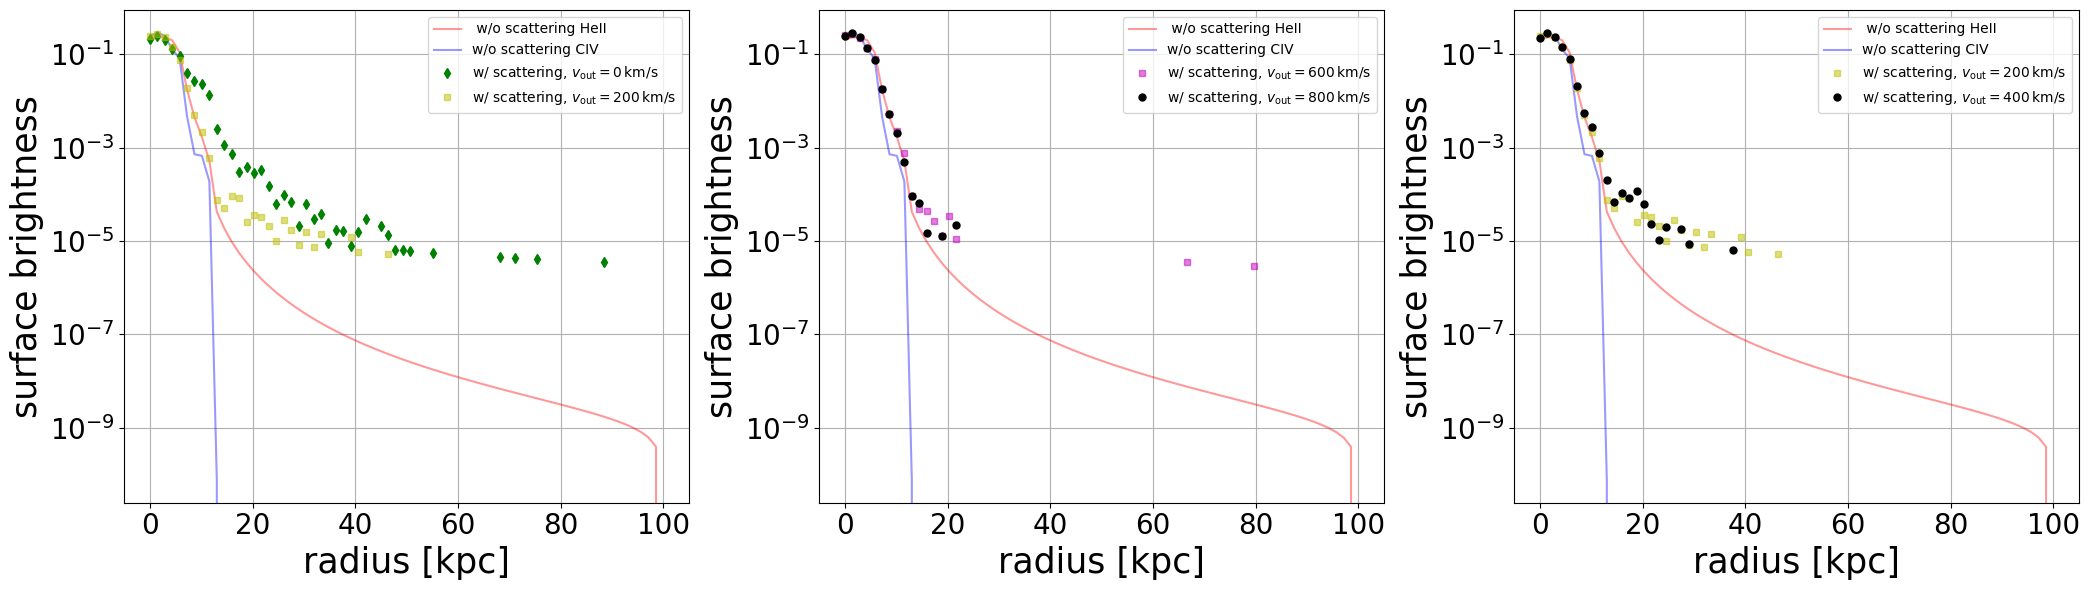

In [15]:
fig = plt.figure(1,figsize=(21,6))


plt.subplot(131)

plt.plot(HeII_p_radius ,HeII_SB/np.sum(HeII_SB),'r-',alpha = 0.4,label=' w/o scattering HeII')
plt.plot(CIV_p_radius ,CIV_SB/np.sum(CIV_SB),'b-',alpha = 0.4,label='w/o scattering CIV')




plt.plot(RT_radius_vout_0 ,RT_SB_vout_0,'gd',ms=5,label=r'w/ scattering, $v_{\rm out} = 0 \, \rm km/s$')
plt.plot(RT_radius_vout_2 ,RT_SB_vout_2,'ys',ms=5, alpha = 0.5, label=r'w/ scattering, $v_{\rm out} = 200 \, \rm km/s$')
# plt.plot(RT_radius_6 ,RT_SB_6,'b*', label=r'w/ scattering, $v_{\rm out} = 600 km/s$')


# plt.xlim(0,15)

plt.grid(True)
plt.yscale('log')
plt.xlabel('radius [kpc]',fontsize=25)
plt.xticks(fontsize=20)
plt.ylabel('surface brightness',fontsize=25)
plt.yticks(fontsize=20)
plt.legend()
plt.tight_layout()


plt.subplot(132)
plt.plot(HeII_p_radius ,HeII_SB/np.sum(HeII_SB),'r-',alpha = 0.4,label=' w/o scattering HeII')
plt.plot(CIV_p_radius ,CIV_SB/np.sum(CIV_SB),'b-',alpha = 0.4,label='w/o scattering CIV')



plt.plot(RT_radius_vout_6 ,RT_SB_vout_6,'ms',ms=5,alpha =0.5 ,label=r'w/ scattering, $v_{\rm out} = 600 \, \rm km/s$')
plt.plot(RT_radius_vout_8 ,RT_SB_vout_8,'ko', ms = 5,label=r'w/ scattering, $v_{\rm out} = 800 \, \rm km/s$')



plt.grid(True)
plt.yscale('log')
plt.xlabel('radius [kpc]',fontsize=25)
plt.xticks(fontsize=20)
plt.ylabel('surface brightness',fontsize=25)
plt.yticks(fontsize=20)
plt.legend()
plt.tight_layout()




plt.subplot(133)
plt.plot(HeII_p_radius ,HeII_SB/np.sum(HeII_SB),'r-',alpha = 0.4,label=' w/o scattering HeII')
plt.plot(CIV_p_radius ,CIV_SB/np.sum(CIV_SB),'b-',alpha = 0.4,label='w/o scattering CIV')


plt.plot(RT_radius_vout_2 ,RT_SB_vout_2,'ys',ms=5 ,alpha =0.5,label=r'w/ scattering, $v_{\rm out} = 200 \,  \rm km/s$')
plt.plot(RT_radius_vout_4 ,RT_SB_vout_4,'ko',ms=5, label=r'w/ scattering, $v_{\rm out} = 400 \, \rm km/s$')

# plt.xlim(0,25)

plt.grid(True)
plt.yscale('log')
plt.xlabel('radius [kpc]',fontsize=25)
plt.xticks(fontsize=20)
plt.ylabel('surface brightness',fontsize=25)
plt.yticks(fontsize=20)
plt.legend()
plt.tight_layout()

# plt.savefig(r'/home/jin/바탕화면/outflow_case.png')

RT with intrinsic emission width

In [9]:
vout = 200
vemit = np.array([1,50,100,200,300])
vrand = 11.8
vemit_make_parameter(vout,vemit,vrand)


make parameters of v_rand = 11.8 km/s, v_exp = 200 km/s, v_emit = 1 km/s for CIV
make parameters of v_rand = 11.8 km/s, v_exp = 200 km/s, v_emit = 50 km/s for CIV
make parameters of v_rand = 11.8 km/s, v_exp = 200 km/s, v_emit = 100 km/s for CIV
make parameters of v_rand = 11.8 km/s, v_exp = 200 km/s, v_emit = 200 km/s for CIV
make parameters of v_rand = 11.8 km/s, v_exp = 200 km/s, v_emit = 300 km/s for CIV
Make data!!


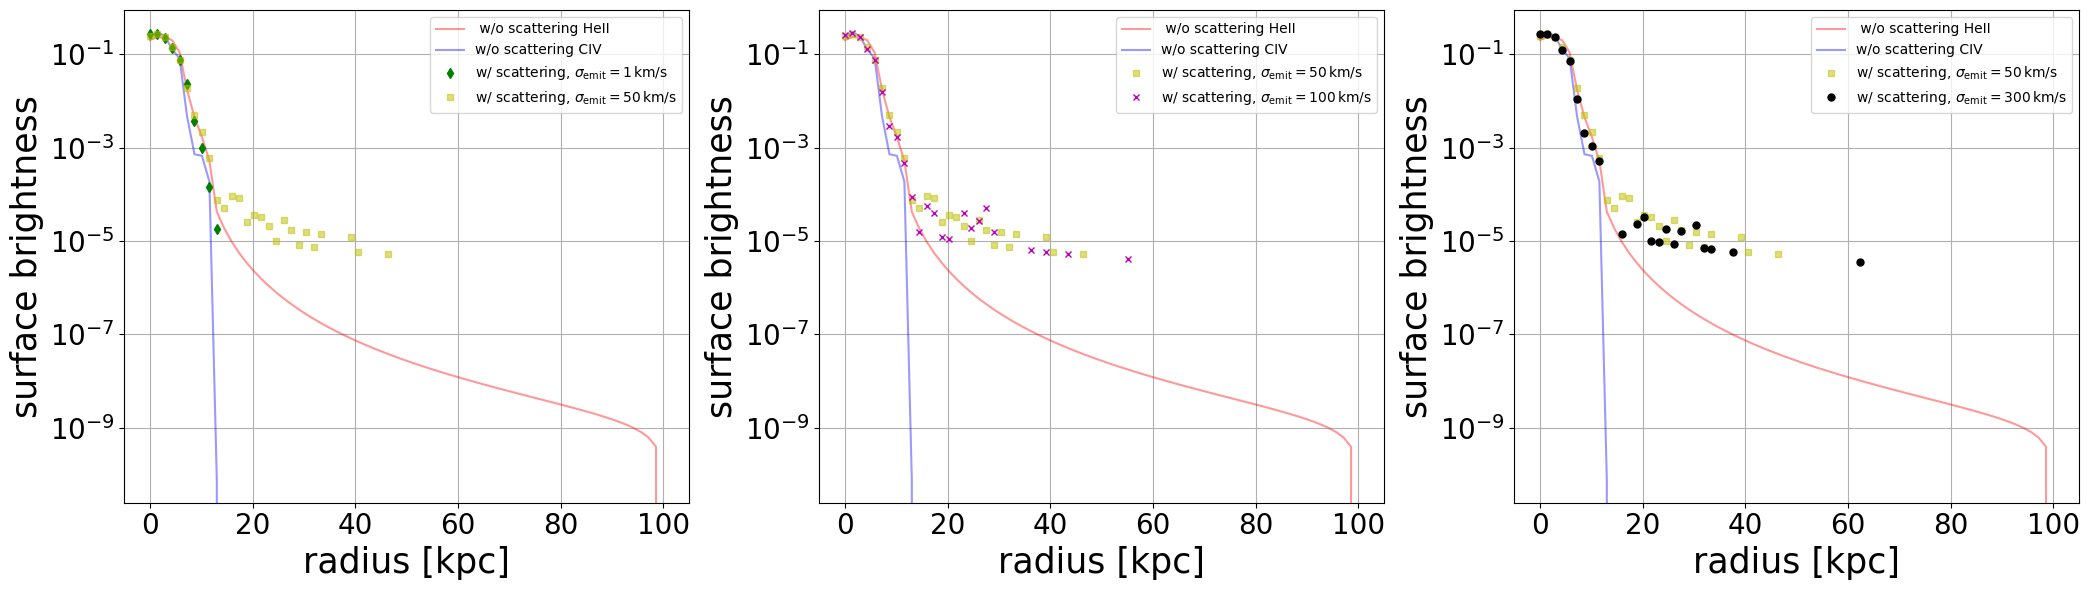

In [10]:
fig = plt.figure(1,figsize=(21,6))


plt.subplot(131)
plt.plot(HeII_p_radius ,HeII_SB/np.sum(HeII_SB),'r-',alpha = 0.4,label=' w/o scattering HeII')
plt.plot(CIV_p_radius ,CIV_SB/np.sum(CIV_SB),'b-',alpha = 0.4,label='w/o scattering CIV')


plt.plot(RT_radius_vemit_0 ,RT_SB_vemit_0,'gd',ms=5,label=r'w/ scattering, $\sigma_{\rm emit} = 1 \, \rm km/s$')
plt.plot(RT_radius_vemit_5 ,RT_SB_vemit_5,'ys',ms=5, alpha = 0.5, label=r'w/ scattering, $\sigma_{\rm emit} = 50 \, \rm km/s$')
# plt.plot(RT_radius_6 ,RT_SB_6,'b*', label=r'w/ scattering, $v_{\rm out} = 600 km/s$')


# plt.xlim(0,15)

plt.grid(True)
plt.yscale('log')
plt.xlabel('radius [kpc]',fontsize=25)
plt.xticks(fontsize=20)
plt.ylabel('surface brightness',fontsize=25)
plt.yticks(fontsize=20)
plt.legend()
plt.tight_layout()


plt.subplot(132)
plt.plot(HeII_p_radius ,HeII_SB/np.sum(HeII_SB),'r-',alpha = 0.4,label=' w/o scattering HeII')
plt.plot(CIV_p_radius ,CIV_SB/np.sum(CIV_SB),'b-',alpha = 0.4,label='w/o scattering CIV')


plt.plot(RT_radius_vemit_5 ,RT_SB_vemit_5,'ys',ms=5,alpha =0.5 ,label=r'w/ scattering, $\sigma_{\rm emit} = 50 \, \rm km/s$')
plt.plot(RT_radius_vemit_10 ,RT_SB_vemit_10,'mx', ms = 5,label=r'w/ scattering, $\sigma_{\rm emit} = 100 \, \rm km/s$')



plt.grid(True)
plt.yscale('log')
plt.xlabel('radius [kpc]',fontsize=25)
plt.xticks(fontsize=20)
plt.ylabel('surface brightness',fontsize=25)
plt.yticks(fontsize=20)
plt.legend()
plt.tight_layout()




plt.subplot(133)
plt.plot(HeII_p_radius ,HeII_SB/np.sum(HeII_SB),'r-',alpha = 0.4,label=' w/o scattering HeII')
plt.plot(CIV_p_radius ,CIV_SB/np.sum(CIV_SB),'b-',alpha = 0.4,label='w/o scattering CIV')


plt.plot(RT_radius_vemit_5 ,RT_SB_vemit_5,'ys',alpha=0.5,ms=5,label=r'w/ scattering, $\sigma_{\rm emit} = 50 \,  \rm km/s$')
plt.plot(RT_radius_vemit_30 ,RT_SB_vemit_30,'ko',ms=5,alpha=1, label=r'w/ scattering, $\sigma_{\rm emit} = 300 \, \rm km/s$')



plt.grid(True)
plt.yscale('log')
plt.xlabel('radius [kpc]',fontsize=25)
plt.xticks(fontsize=20)
plt.ylabel('surface brightness',fontsize=25)
plt.yticks(fontsize=20)
plt.legend()
plt.tight_layout()
plt.savefig(r'/home/jin/바탕화면/emissivity_case.png')

RT with Random motion

In [11]:
vout = 200
vemit = 50
vrand = np.array([11.8,50,100])
vrand_make_parameter(vout,vemit,vrand)


make parameters of v_rand = 11.8 km/s, v_exp = 200 km/s, v_emit = 50 km/s for CIV
make parameters of v_rand = 50.0 km/s, v_exp = 200 km/s, v_emit = 50 km/s for CIV
make parameters of v_rand = 100.0 km/s, v_exp = 200 km/s, v_emit = 50 km/s for CIV
Make data!!


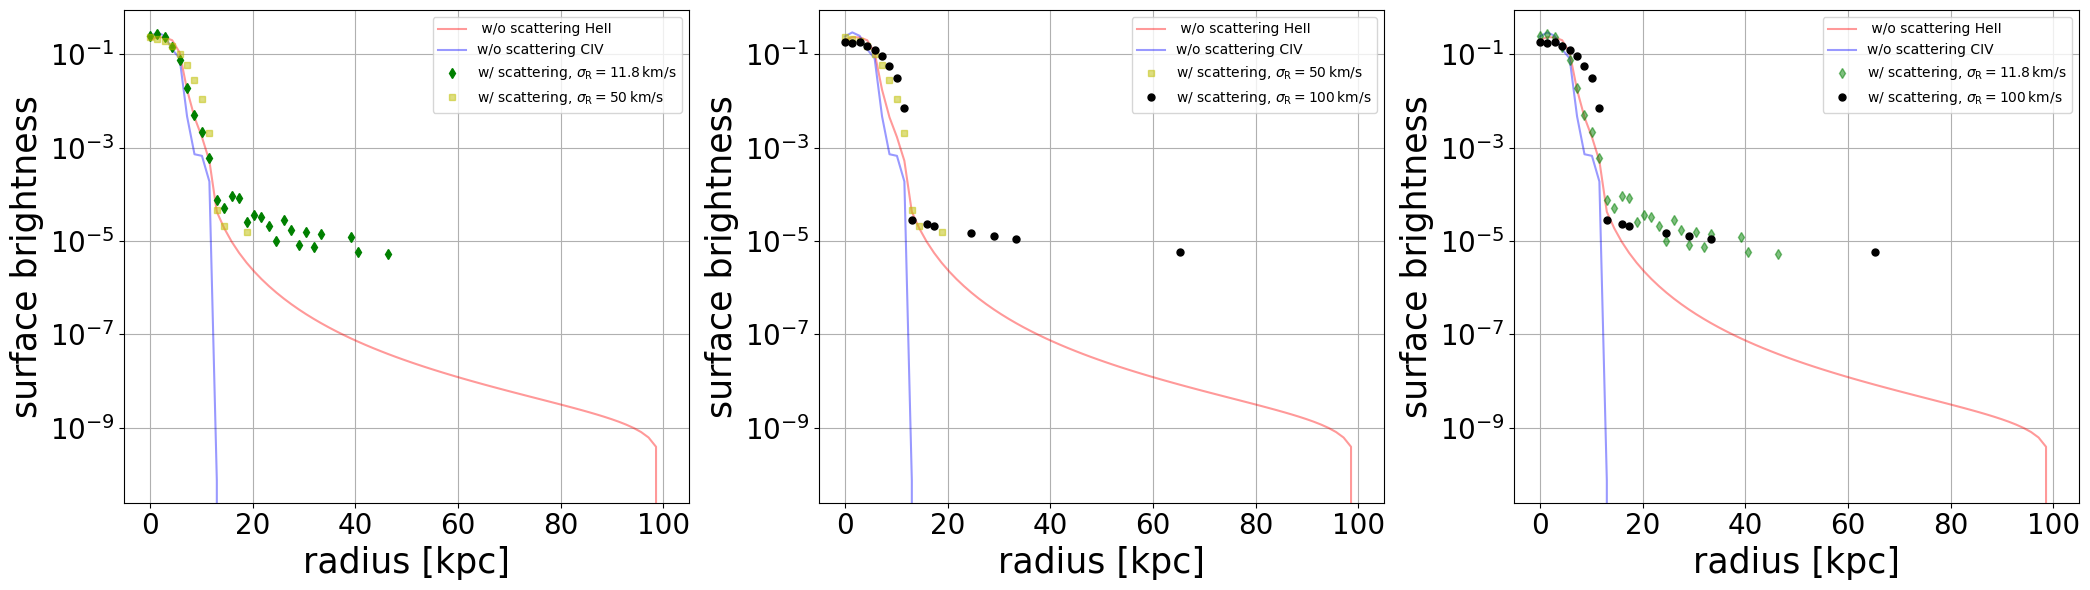

In [12]:
fig = plt.figure(1,figsize=(21,6))


plt.subplot(131)
plt.plot(HeII_p_radius ,HeII_SB/np.sum(HeII_SB),'r-',alpha = 0.4,label=' w/o scattering HeII')
plt.plot(CIV_p_radius ,CIV_SB/np.sum(CIV_SB),'b-',alpha = 0.4,label='w/o scattering CIV')


plt.plot(RT_radius_vrand_1 ,RT_SB_vrand_1,'gd',ms=5,label=r'w/ scattering, $\sigma_{\rm R} = 11.8 \, \rm km/s$')
plt.plot(RT_radius_vrand_5 ,RT_SB_vrand_5,'ys',ms=5, alpha = 0.5, label=r'w/ scattering, $\sigma_{\rm R} = 50 \, \rm km/s$')
# plt.plot(RT_radius_6 ,RT_SB_6,'b*', label=r'w/ scattering, $v_{\rm out} = 600 km/s$')


# plt.xlim(0,15)

plt.grid(True)
plt.yscale('log')
plt.xlabel('radius [kpc]',fontsize=25)
plt.xticks(fontsize=20)
plt.ylabel('surface brightness',fontsize=25)
plt.yticks(fontsize=20)
plt.legend()
plt.tight_layout()


plt.subplot(132)
plt.plot(HeII_p_radius ,HeII_SB/np.sum(HeII_SB),'r-',alpha = 0.4,label=' w/o scattering HeII')
plt.plot(CIV_p_radius ,CIV_SB/np.sum(CIV_SB),'b-',alpha = 0.4,label='w/o scattering CIV')


plt.plot(RT_radius_vrand_5 ,RT_SB_vrand_5,'ys',ms=5,alpha =0.5 ,label=r'w/ scattering, $\sigma_{\rm R} = 50 \, \rm km/s$')
plt.plot(RT_radius_vrand_10 ,RT_SB_vrand_10,'ko', ms = 5,label=r'w/ scattering, $\sigma_{\rm R} = 100 \, \rm km/s$')



plt.grid(True)
plt.yscale('log')
plt.xlabel('radius [kpc]',fontsize=25)
plt.xticks(fontsize=20)
plt.ylabel('surface brightness',fontsize=25)
plt.yticks(fontsize=20)
plt.legend()
plt.tight_layout()

plt.subplot(133)
plt.plot(HeII_p_radius ,HeII_SB/np.sum(HeII_SB),'r-',alpha = 0.4,label=' w/o scattering HeII')
plt.plot(CIV_p_radius ,CIV_SB/np.sum(CIV_SB),'b-',alpha = 0.4,label='w/o scattering CIV')


plt.plot(RT_radius_vrand_1 ,RT_SB_vrand_1,'gd',ms=5,alpha =0.5 ,label=r'w/ scattering, $\sigma_{\rm R} = 11.8 \, \rm km/s$')
plt.plot(RT_radius_vrand_10 ,RT_SB_vrand_10,'ko', ms = 5,label=r'w/ scattering, $\sigma_{\rm R} = 100 \, \rm km/s$')



plt.grid(True)
plt.yscale('log')
plt.xlabel('radius [kpc]',fontsize=25)
plt.xticks(fontsize=20)
plt.ylabel('surface brightness',fontsize=25)
plt.yticks(fontsize=20)
plt.legend()
plt.tight_layout()

# plt.title()

plt.savefig(r'/home/jin/바탕화면/random_case.png')
